In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

%matplotlib inline
plt.style.use('ggplot')

# Load data

In [2]:
# load data and use first column as datetime index
df = pd.read_csv('data/equity_RN628A_hbase_data.csv', header=0, 
                 names=['timestamp', 'load', 'temp', 'date', 'time', 'dow', 'month'],
                 index_col=0, parse_dates=[0,3])
df.index.name = None

df.head(10)

# check if data is correct
(df.index.dayofweek == df['dow']).all()

False

## Incorrect values

Looks like values for `dow`, `date`, etc. given don't match up with timestamp. I will just fix these by calculating my own.

In [3]:
df.drop(['date', 'time', 'dow', 'month'], axis=1, inplace=True)

In [4]:
df['date'] = df.index.date
df['month'] = df.index.month
df['dow'] = df.index.dayofweek
df['hour'] = df.index.hour

In [5]:
df.head(10)

,load,temp,date,month,dow,hour
2012-11-01 08:00:00,NaN,60.1,2012-11-01,11,3,8
2012-11-01 08:15:00,NaN,NaN,2012-11-01,11,3,8
2012-11-01 08:30:00,NaN,NaN,2012-11-01,11,3,8
2012-11-01 08:45:00,NaN,NaN,2012-11-01,11,3,8
2012-11-01 09:00:00,NaN,60.1,2012-11-01,11,3,9
2012-11-01 09:15:00,NaN,60.8,2012-11-01,11,3,9
2012-11-01 09:30:00,NaN,60.8,2012-11-01,11,3,9
2012-11-01 09:45:00,NaN,NaN,2012-11-01,11,3,9
2012-11-01 10:00:00,NaN,60.1,2012-11-01,11,3,10
2012-11-01 10:15:00,NaN,NaN,2012-11-01,11,3,10


# Missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45505 entries, 2012-11-01 08:00:00 to 2014-02-18 08:00:00
Data columns (total 6 columns):
load     37916 non-null float64
temp     12307 non-null float64
date     45505 non-null object
month    45505 non-null int32
dow      45505 non-null int32
hour     45505 non-null int32
dtypes: float64(2), int32(3), object(1)
memory usage: 1.9+ MB


## Temperature

Choices were to:
 - forward fill
 - back fill
 - linear interpolation
 
I decided to linearly interpolate because this most closely matches how temperature changes in reality

In [7]:
# linearly interpolate missing temperature values
df['temp'] = df['temp'].interpolate()

## Load

There are 7589 missing values for load data. I suspect these are missing from the beginning and end of the time series but let's just check to be sure

In [8]:
# get all unique dates for missing load values
np.unique(df.index[df['load'].isnull()].map(lambda ts: ts.date()))

array([datetime.date(2012, 11, 1), datetime.date(2012, 11, 2),
       datetime.date(2012, 11, 4), datetime.date(2013, 11, 3),
       datetime.date(2013, 12, 2), datetime.date(2013, 12, 3),
       datetime.date(2013, 12, 4), datetime.date(2013, 12, 5),
       datetime.date(2013, 12, 6), datetime.date(2013, 12, 7),
       datetime.date(2013, 12, 8), datetime.date(2013, 12, 9),
       datetime.date(2013, 12, 10), datetime.date(2013, 12, 11),
       datetime.date(2013, 12, 12), datetime.date(2013, 12, 13),
       datetime.date(2013, 12, 14), datetime.date(2013, 12, 15),
       datetime.date(2013, 12, 16), datetime.date(2013, 12, 17),
       datetime.date(2013, 12, 18), datetime.date(2013, 12, 19),
       datetime.date(2013, 12, 20), datetime.date(2013, 12, 21),
       datetime.date(2013, 12, 22), datetime.date(2013, 12, 23),
       datetime.date(2013, 12, 24), datetime.date(2013, 12, 25),
       datetime.date(2013, 12, 26), datetime.date(2013, 12, 27),
       datetime.date(2013, 12, 28), d

As I suspected, missing load values are basically for dates before November 5th, 2012 and also after December 1st, 2013. I will cut these values off.

In [9]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37916 entries, 2012-11-02 07:15:00 to 2013-12-02 08:00:00
Data columns (total 6 columns):
load     37916 non-null float64
temp     37916 non-null float64
date     37916 non-null object
month    37916 non-null int32
dow      37916 non-null int32
hour     37916 non-null int32
dtypes: float64(2), int32(3), object(1)
memory usage: 1.6+ MB


# Data analysis

## First month

Now that our data is cleaned up, let's take a look at it. I'm going to start by looking at the first month - November 2012. 

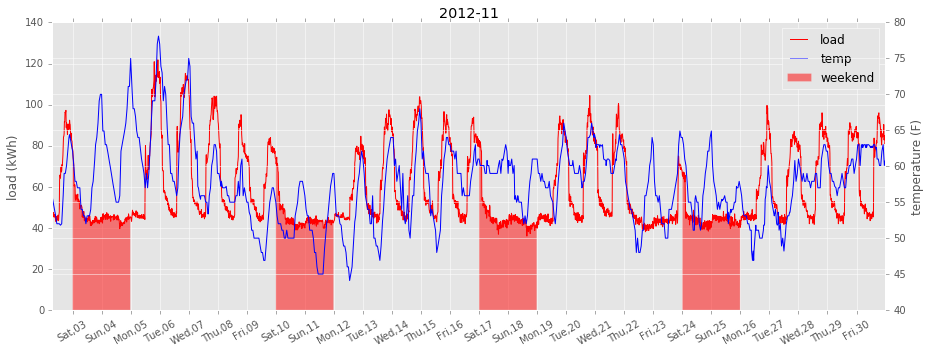

In [102]:
f,ax = plt.subplots()
# get first month
first = df['2012-11']
# plot load line
loadln = ax.plot(first.index, first['load'], 'r-', label='load')
ax.set_ylabel('load (kWh)')
# highlight weekends
fillarea = ax.fill_between(first.index, first['load'], where = first['dow'] > 4, 
                facecolor = 'red', alpha = 0.5, label='weekend')
# make second axes sharing x
ax2 = ax.twinx()
ax2.set_ylabel('temperature (F)')
# plot temperature
templn = ax2.plot(first.index, first['temp'], 'b-', label='temp')
# get both lines and area
lns = loadln+templn+[fillarea]
# get all labels
labs = [l.get_label() for l in lns]
# merged legend
ax.legend(lns, labs)
# make tick everyday
ax.xaxis.set_major_locator(mdates.DayLocator())
# format with dow and date
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a,%d'))
# rotate xticks
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)
# set title
ax.set_title('2012-11')
# make bigger
f.set_size_inches(13, 5)
# and tighter
plt.tight_layout()

### Trend

From this first month it appears that temperature and load are highly correlated. The overall relative magnitude of load (at least on weekdays) follows temperature very closely.

There doesn't appear to be a strong trend overall, although there is a pretty clear downward trend the first week of November.

### Seasonality

We can clearly see some daily seasonality with the load with peak happening in middle of day and lower load at beginnning and end. __But__, we only see this on weekdays! The load seems to relatively flat on weekends. 

### Anomalies

In 2012, American Thanksgiving - a national holiday - was on Thursday November 22nd. The day after is usually also a holiday. We can see that even though these two days were weekdays, the load actually matches what we would typically observe for weekend usage. There is a spike close to midnight on Black Friday (24th).

## Remainder

In [41]:
current = df['2012-11']
current[['load', 'temp']]
current['load']
current.index

DatetimeIndex(['2012-11-02 07:15:00', '2012-11-02 07:30:00',
               '2012-11-02 07:45:00', '2012-11-02 08:00:00',
               '2012-11-02 08:15:00', '2012-11-02 08:30:00',
               '2012-11-02 08:45:00', '2012-11-02 09:00:00',
               '2012-11-02 09:15:00', '2012-11-02 09:30:00',
               ...
               '2012-11-30 21:30:00', '2012-11-30 21:45:00',
               '2012-11-30 22:00:00', '2012-11-30 22:15:00',
               '2012-11-30 22:30:00', '2012-11-30 22:45:00',
               '2012-11-30 23:00:00', '2012-11-30 23:15:00',
               '2012-11-30 23:30:00', '2012-11-30 23:45:00'],
              dtype='datetime64[ns]', length=2751, freq=None)

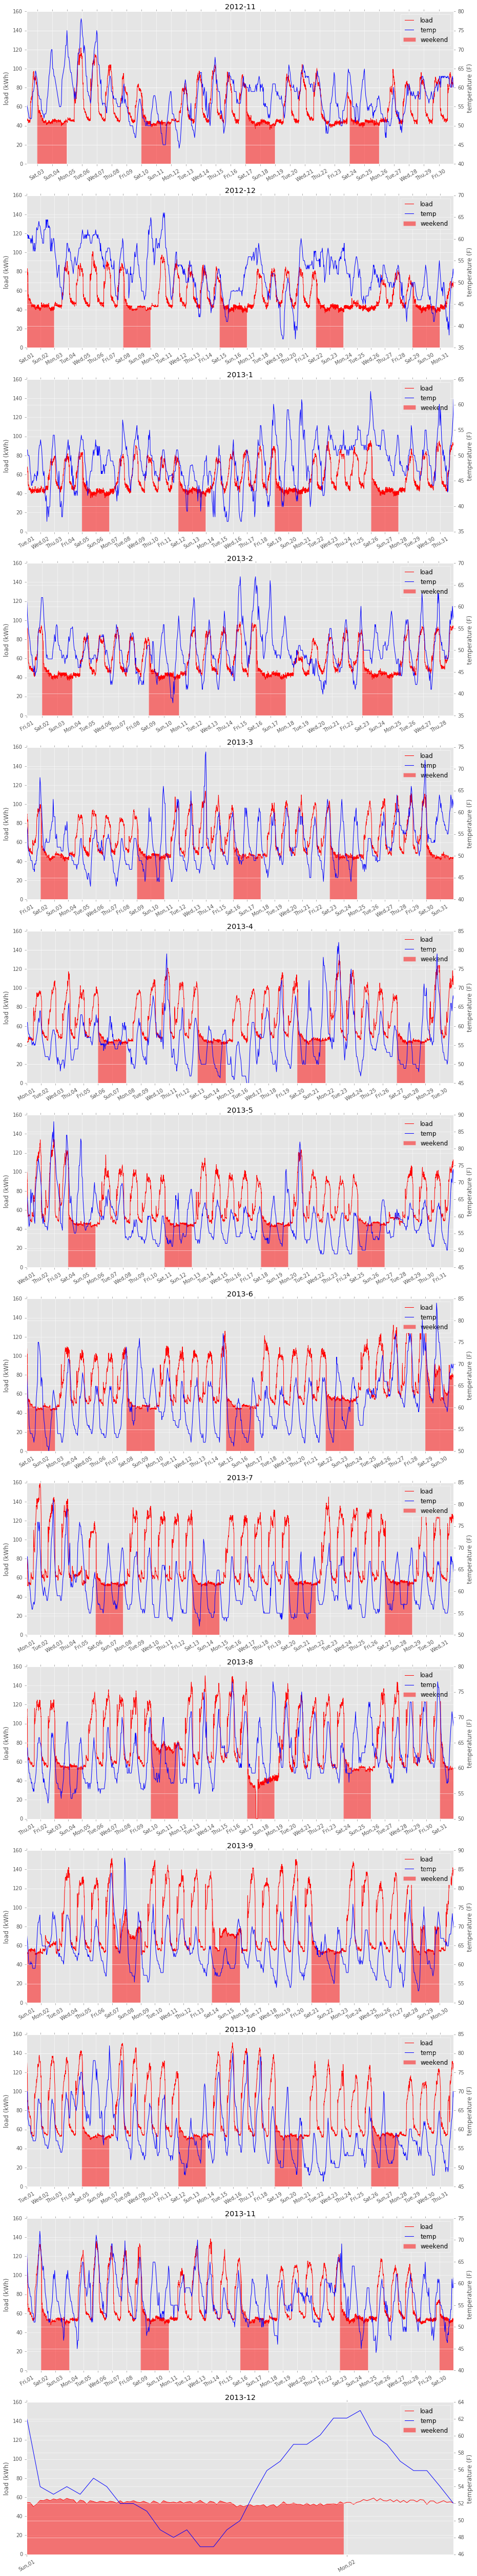

In [103]:
months = ['2012-11', '2012-12']
months.extend(['2013-{}'.format(m) for m in range(1,13)])
f, axes = plt.subplots(14, sharey=True)
for i, ax in enumerate(axes):
    current = df[months[i]]
    loadln = ax.plot(current.index, current['load'], 'r-', label='load')
    ax.set_ylabel('load (kWh)')
    fillarea = ax.fill_between(current.index, current['load'], where = current['dow'] > 4, 
                    facecolor = 'red', alpha = 0.5, label='weekend')
    ax2 = ax.twinx()
    templn = ax2.plot(current.index, current['temp'], 'b-', label='temp')
    ax2.set_ylabel('temperature (F)')
    lns = loadln+templn+[fillarea]
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a,%d'))
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=10)
    ax.set_title(months[i])
f.set_size_inches(13, 70)
plt.tight_layout()

### Trends

It's not super clear by looking at the individual months but there is a definite overall trend of increasing usage in the winter months.

### Seasonality

Daily cycles are seen throughout the year. 

### Anomalies

Memorial Day (Monday May 27, 2013) is another holiday that seemed to mimic load that is typical of weekends. 

There were a few weekends that didn't appear to be as flat as weekends typically are (June 29-30, September 7-8, September 28-29). 

It appears there may have been some kind of outage on August 17th 2013. I doubt I'll be able to actually predict this outage/anomaly given the data I have but luckily it is only one instance. 

## Seasonal trends

I want to get a sense of the larger trend and so I will calculate a daily averages for load and temperature and plot those instead.

In [93]:
dailydf = df.resample('D').sum()

dailydf['temp'] = df['temp'].resample('D').mean()

dailydf['date'] = dailydf.index.date
dailydf['month'] = dailydf.index.month
dailydf['dow'] = dailydf.index.dayofweek
dailydf['hour'] = dailydf.index.hour

dailydf.head(10)

,load,temp,month,dow,hour,date
2012-11-02,4645.20,56.868657,11,4,0,2012-11-02
2012-11-03,4636.20,58.273437,11,5,0,2012-11-03
2012-11-04,4084.95,62.324457,11,6,0,2012-11-04
2012-11-05,6743.70,65.822917,11,0,0,2012-11-05
2012-11-06,7299.00,65.585417,11,1,0,2012-11-06
2012-11-07,6816.00,60.323438,11,2,0,2012-11-07
2012-11-08,6220.50,56.768750,11,3,0,2012-11-08
2012-11-09,5909.70,51.729167,11,4,0,2012-11-09
2012-11-10,4499.40,52.814062,11,5,0,2012-11-10
2012-11-11,4124.70,50.815104,11,6,0,2012-11-11


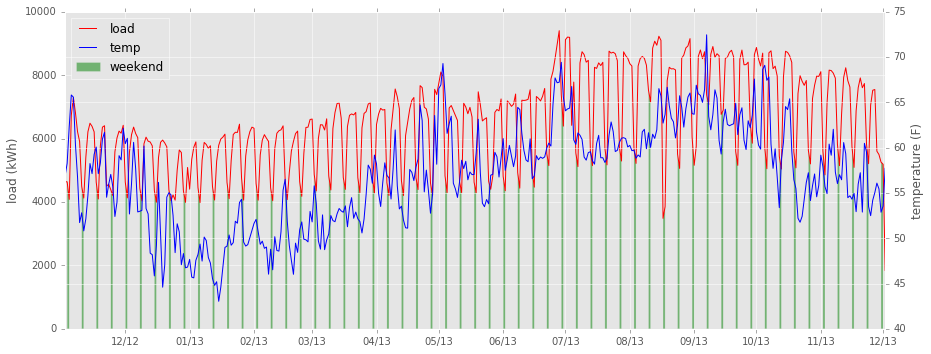

In [105]:
f,ax = plt.subplots()
# plot load line
loadln = ax.plot(dailydf.index, dailydf['load'], 'r-', label='load')
ax.set_ylabel('load (kWh)')
# highlight weekends
fillarea = ax.fill_between(dailydf.index, dailydf['load'], where = dailydf['dow'] > 4, 
                facecolor = 'green', alpha = 0.5, label='weekend')
# make second axes sharing x
ax2 = ax.twinx()
# plot temperature
templn = ax2.plot(dailydf.index, dailydf['temp'], 'b-', label='temp')
ax2.set_ylabel('temperature (F)')
# get both lines and area
lns = loadln+templn+[fillarea]
# get all labels
labs = [l.get_label() for l in lns]
# merged legend
ax.legend(lns, labs, loc=0)
# make tick everyday
ax.xaxis.set_major_locator(mdates.MonthLocator())
# format with dow and date
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
# make bigger
f.set_size_inches(13, 5)
# and tighter
plt.tight_layout()

## Trends

It does look like there is actually just an overall increase in load over this year - especially if we compare December 2012 to December 2013. 

It doesn't actually look like load and temperature trends follow each other that closely here. For example, load is within a realtively constant range from November 2012 to March 2013 but during this time temperature has changed quite significantly.

## Seasonality

Dips still correspond with weekends.